# CRNN Notebook

In [ ]:
!pip install torcheval

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset ,DataLoader, WeightedRandomSampler
from torch.utils.data.dataset import Subset
from torch.utils.data import random_split
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import json
from torcheval.metrics import MulticlassF1Score
import matplotlib.pyplot as plt

1. use f1 score
2. dont use weighted average for test and validation
3. dont transform validation and test set
4. check for overlap of images

# Data Augmentation and DataLoader Preparation

In this section, we define the transformations for data augmentation to increase the diversity of our dataset, which can lead to better model generalization. Following that, we instantiate our Alzheimer's dataset class with these transformations and then split the dataset into training, validation, and test sets. To tackle the class imbalance issue, we compute class weights and use these to create a weighted sampler for the training data. Finally, we prepare DataLoader objects for each dataset split to facilitate efficient data loading during the model training and evaluation phases.

To address class imbalance, we implement a weight rebalancing strategy that ensures less frequent classes are given more importance during training. This is done through the following steps:

1. **Calculate Class Sample Counts**: We compute the number of samples present for each class in the dataset. This count helps identify the imbalance and determine the weight each class should receive.

2. **Compute Class Weights**: The weight for each class is calculated as the inverse of its sample count. This approach assigns higher weights to less frequent classes, thus increasing their influence during the model training process.

3. **Assign Sample Weights**: We then assign a weight to each sample in the dataset corresponding to its class weight. This results in a weighted distribution where each sample's importance is reflected by its weight.

4. **Weighted Random Sampler**: In the training DataLoader, we use a WeightedRandomSampler with these sample weights. This sampler ensures that batches of data are sampled in a manner that reflects the assigned weights, giving more representation to underrepresented classes and mitigating the effects of class imbalance.

By rebalancing the weights, we ensure that the model does not overlook the minority classes and learns to generalize well across all classes, leading to a more balanced and fair prediction outcome.


# Series Dataset

In [ ]:
class AlzheimerSeriesDataset(Dataset):
    """
    A custom Dataset class for handling series of MRI images, where each series represents a single patient's scan.

    Attributes:
        root_dir (str): Directory containing image categories.
        transform (callable, optional): Transform to be applied to each image in a series.
        series_paths (list): List of paths for each image in the series.
        labels (list): List of labels corresponding to each series.
    """

    def __init__(self, root_dir, transform=None):
        """
        Initializes the dataset object, storing paths for series of images and their labels.

        Args:
            root_dir (str): Directory containing image categories.
            transform (callable, optional): Transform to apply to each image in the series.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.series_paths = []
        self.labels = []

        categories = ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']
        label_mapping = {category: idx for idx, category in enumerate(categories)}

        # Organize images into series based on patient ID
        for category in categories:
            category_path = os.path.join(root_dir, category)
            patient_series = {}  # Dictionary to hold image paths for each patient

            # Aggregate images into series based on patient ID
            for img_name in os.listdir(category_path):
                patient_id = '_'.join(img_name.split('_')[:-1])
                img_path = os.path.join(category_path, img_name)

                if patient_id not in patient_series:
                    patient_series[patient_id] = []
                patient_series[patient_id].append(img_path)

            # Store only complete series with the correct number of images
            for patient_id, img_paths in patient_series.items():
                if len(img_paths) == 61:  # Assuming each series should have 61 images
                    self.series_paths.append(sorted(img_paths))  # Ensure images are in order
                    self.labels.append(label_mapping[category])

    def __len__(self):
        """
        Returns the total number of series in the dataset.
        """
        return len(self.series_paths)

    def __getitem__(self, idx):
        """
        Retrieves a series of images and its label at the specified index.

        Args:
            idx (int): Index of the data series to retrieve.

        Returns:
            series_stack (torch.Tensor): The stack of images corresponding to the series.
            label (int): The label of the series.
        """
        series_paths = self.series_paths[idx]
        series_images = [Image.open(img_path).convert('L') for img_path in series_paths]  # Convert images to grayscale

        # Apply transformation to each image in the series if a transform is specified
        if self.transform:
            series_images = [self.transform(image) for image in series_images]

        # Stack images to form a tensor representing the series
        series_stack = torch.stack(series_images, dim=0)
        label = self.labels[idx]

        return series_stack, label

In [ ]:
# Initialize the dataset without any transformations
dataset = AlzheimerSeriesDataset(root_dir='../Data')

# Define the sizes for train, validation, and test sets
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Define transformations for data augmentation for the training set
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Apply transformations to the training dataset
train_dataset = Subset(dataset, train_dataset.indices)
train_dataset.dataset.transform = train_transform

val_dataset = Subset(dataset, val_dataset.indices)
val_dataset.dataset.transform = val_test_transform

test_dataset = Subset(dataset, test_dataset.indices)
test_dataset.dataset.transform = val_test_transform

# Calculate class weights for balancing
class_sample_count = np.array([len(np.where(np.array(dataset.labels) == t)[0]) for t in np.unique(dataset.labels)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in dataset.labels])
train_weights = np.array([samples_weight[idx] for idx in train_dataset.indices])

# Create the sampler for the training set
train_sampler = WeightedRandomSampler(train_weights, len(train_weights))

# Number of workers for data loading
num_workers = 1

# Create the DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    sampler=train_sampler,
    num_workers=num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

# Defining a Common Training Function for All Models

In this section, we define a universal training function that can be applied to all models since they share common inputs and outputs. This function will handle the model training and validation processes, including features like saving model checkpoints, tracking training and validation metrics, and optionally performing parameter search to find the optimal model configuration. We use a common training function streamlines the training process across different models, ensuring consistency and reducing code redundancy.

In [ ]:
def train_model(model, train_loader, val_loader, device, model_checkpoint_path, model_name, epochs=5, load_pretrained=False, last_epoch=-1):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    best_val_loss = float('inf')
    best_val_accuracy = 0
    best_epoch = 0

    train_loss_history = []
    train_accuracy_history = []
    train_f1score_history = []
    val_loss_history = []
    val_accuracy_history = []
    val_f1score_history = []

    NUM_CLASSES = 4  # replace with your actual number of classes

    # Initialize torcheval F1 score computation
    f1_score_train = MulticlassF1Score(num_classes=NUM_CLASSES)
    f1_score_val = MulticlassF1Score(num_classes=NUM_CLASSES)

    # Create model checkpoint directory if it doesn't exist
    model_save_dir = os.path.join(model_checkpoint_path, model_name)
    os.makedirs(model_save_dir, exist_ok=True)

    if load_pretrained and last_epoch >= 0:
        model_save_path = os.path.join(model_save_dir, f'epoch_{last_epoch}.pth')
        if os.path.isfile(model_save_path):
            print(f"Loading pretrained model from {model_save_path}")
            model.load_state_dict(torch.load(model_save_path, map_location=device))
            print("Model loaded successfully.")
        else:
            print(f"No pretrained model found at {model_save_path}, starting training from scratch.")

    try:
        for epoch in range(last_epoch + 1, last_epoch + 1 + epochs):
            model.train()
            train_loss, train_correct, train_total = 0, 0, 0

            f1_score_train.reset()
            f1_score_val.reset()

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()

                # Update F1 score
                f1_score_train.update(predicted, labels)

            train_loss /= len(train_loader)
            train_accuracy = train_correct / train_total
            train_f1score = f1_score_train.compute()

            train_loss_history.append(train_loss)
            train_accuracy_history.append(train_accuracy)
            train_f1score_history.append(train_f1score)

            model.eval()
            val_loss, val_correct, val_total = 0, 0, 0

            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()

                    # Update F1 score
                    f1_score_val.update(predicted, labels)

            val_loss /= len(val_loader)
            val_accuracy = val_correct / val_total
            val_f1score = f1_score_val.compute()

            val_loss_history.append(val_loss)
            val_accuracy_history.append(val_accuracy)
            val_f1score_history.append(val_f1score)

            print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1: {train_f1score:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1: {val_f1score:.4f}')

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_val_accuracy = val_accuracy
                best_epoch = epoch
                model_save_path = os.path.join(model_save_dir, f'epoch_{epoch}.pth')
                torch.save(model.state_dict(), model_save_path)
                print(f'Model saved to {model_save_path}')

            torch.cuda.empty_cache()

    except KeyboardInterrupt:
        print("Training interrupted, saving current state...")
        model_save_path = os.path.join(model_save_dir, 'interrupted.pth')
        torch.save(model.state_dict(), model_save_path)
        print(f"Model and training state saved to {model_save_path}")

    return {
        'model_name': model_name,
        'best_epoch': best_epoch,
        'best_val_accuracy': best_val_accuracy,
        'epochs_trained': epoch + 1,
        'train_loss_history': train_loss_history,
        'train_accuracy_history': train_accuracy_history,
        'train_f1score_history': train_f1score_history,
        'val_loss_history': val_loss_history,
        'val_accuracy_history': val_accuracy_history,
        'val_f1score_history': val_f1score_history
    }


# Model Architecture
## Convolutional Layers
1. The first part of the network consists of convolutional layers. These layers are responsible for extracting spatial features from the input images.
2. The conv1, conv2, conv3 layers, with corresponding batch normalization (bn1, bn2, bn3) and dropout layers (dropout1, dropout2, dropout3), are used to progressively reduce the spatial dimensions of the input while increasing the depth (number of channels), which helps in learning more complex features.
3. The pool1, pool2, pool3 are max-pooling layers that reduce the spatial size of the representation, thereby reducing the number of parameters and computation in the network.

## LSTM Layer
After the convolutional layers, the spatial features are reshaped and fed into an LSTM layer, turning spatial features obtained in convolutional layers into a 256-dimensional representation.
The LSTM (rnn1) is designed to handle sequential data and can maintain long-term dependencies in sequences. It’s particularly useful in this case for 2 main reasons:
1. Ability to recognise appearance across sequence: CRNNs are good at recognizing patterns that vary in their appearance across a sequence. This is particularly useful in the case of MRI scans of the brain as each patient's brain had 61 scans corresponding to the axis of their brains, allowing the RNN to learn how the appearance of brain scans vary across each cross-section.
2. Learn long term relationship between different parts of image: RNN allows the model to learn the relationship between different parts of the image, and preserve this knowledge accross the training. This could have contributed in the model learning common spatial features present across images which help to classify images better.

## Linear Layer (Dense Layer)
The last part of the model is a linear layer, dense, that maps the LSTM outputs to the 4 different classes.

### Forward Pass
In the forward method, the input data passes through the convolutional layers first. Here, features are extracted and downsampled.
Then, the data is reshaped and permuted to match the input requirements of an LSTM. Specifically, it's transformed into a format of [sequence_length, batch_size, features].
The LSTM processes this sequential data, and the output from the last sequence step is passed through the dense layer to produce the final output.

In [ ]:
class CRNN(nn.Module):
    def __init__(self, num_classes=4, hidden_dim=64, lstm_layers=1):
        super(CRNN, self).__init__()
        self.hidden_dim = hidden_dim

        # Define convolutional layers with 61 as initial channel size
        self.conv1 = nn.Conv2d(61, 61, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(61)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(61, 61, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(61)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(61, 61, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(61)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(1922, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

        self.lstm = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=lstm_layers, batch_first=True)

    def forward(self, x):
        # Input shape: (batch_size, series_length, channels, height, width)
        batch_size, series_length, channels, height, width = x.size()

        # Merge batch and series length dimensions and treat series as channels
        x = x.view(batch_size, series_length * channels, height, width)

        # Convolutional blocks with modified skip connections to avoid in-place operations
        identity = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = x + identity  # Skip connection, avoid in-place operation
        x = self.pool1(x)

        identity = x
        x = F.relu(self.bn2(self.conv2(x)))
        x = x + identity  # Skip connection, avoid in-place operation
        x = self.pool2(x)

        identity = x
        x = F.relu(self.bn3(self.conv3(x)))
        x = x + identity  # Skip connection, avoid in-place operation
        x = self.pool3(x)


        # Flatten and pass through linear layer
        x = x.view(batch_size, series_length * channels, -1)  # Flatten height and width only
        x = self.fc1(x)

        # LSTM layer
        lstm_out, (hidden, _) = self.lstm(x)
        x = lstm_out[:, -1, :]  # Take last time step's output

        # Classifier
        x = self.fc2(x)
        return x

In [ ]:
crnn = CRNN()
print(crnn)

CRNN(
  (conv1): Conv2d(61, 61, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(61, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(61, 61, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(61, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(61, 61, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(61, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1922, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=4, bias=True)
  (lstm): LSTM(64, 64, batch_first=True)
)


# Training CRNN Model

In [ ]:
model_checkpoint_path = 'ModelCheckpointsDebug'
model_name = 'CRNNModel'

crnn_model = CRNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For parameter search (one epoch with metrics return)
performance_indicators2 = train_model(crnn_model,
                                     train_loader,
                                     val_loader,
                                     device,
                                     model_checkpoint_path,
                                     model_name,
                                     epochs=50,
                                     last_epoch=-1,
                                     load_pretrained=False)
print(performance_indicators2)

Epoch 1: Train Loss: 1.0191, Accuracy: 0.5106, F1: 0.5106, Val Loss: 1.5037, Accuracy: 0.0991, F1: 0.0991
Model saved to ModelCheckpointsDebug/CRNNModel/epoch_0.pth
Epoch 2: Train Loss: 0.7022, Accuracy: 0.6579, F1: 0.6579, Val Loss: 0.7887, Accuracy: 0.7453, F1: 0.7453
Model saved to ModelCheckpointsDebug/CRNNModel/epoch_1.pth
Epoch 3: Train Loss: 0.4787, Accuracy: 0.7518, F1: 0.7518, Val Loss: 1.0424, Accuracy: 0.5000, F1: 0.5000
Epoch 4: Train Loss: 0.3737, Accuracy: 0.8153, F1: 0.8153, Val Loss: 0.6503, Accuracy: 0.7264, F1: 0.7264
Model saved to ModelCheckpointsDebug/CRNNModel/epoch_3.pth
Epoch 5: Train Loss: 0.3521, Accuracy: 0.8254, F1: 0.8254, Val Loss: 0.8093, Accuracy: 0.6274, F1: 0.6274
Epoch 6: Train Loss: 0.2957, Accuracy: 0.8648, F1: 0.8648, Val Loss: 0.6532, Accuracy: 0.7453, F1: 0.7453
Epoch 7: Train Loss: 0.1981, Accuracy: 0.9284, F1: 0.9284, Val Loss: 0.6332, Accuracy: 0.7877, F1: 0.7877
Model saved to ModelCheckpointsDebug/CRNNModel/epoch_6.pth
Epoch 8: Train Loss: 0

In [ ]:
model_checkpoint_path = 'ModelCheckpointsDebug'
model_name = 'CRNNModel'
# Plot CRNN Training Log

Loading pretrained model from ModelCheckpointsDebug/CRNNModel/epoch_12.pth
Model loaded successfully.
Epoch 14: Train Loss: 0.0941, Accuracy: 0.9667, F1: 0.9667, Val Loss: 0.1007, Accuracy: 0.9623, F1: 0.9623
Model saved to ModelCheckpointsDebug/CRNNModel/epoch_13.pth
Epoch 15: Train Loss: 0.0402, Accuracy: 0.9879, F1: 0.9879, Val Loss: 0.1477, Accuracy: 0.9528, F1: 0.9528
Epoch 16: Train Loss: 0.0194, Accuracy: 0.9960, F1: 0.9960, Val Loss: 0.1636, Accuracy: 0.9670, F1: 0.9670
Epoch 17: Train Loss: 0.0455, Accuracy: 0.9828, F1: 0.9828, Val Loss: 0.2707, Accuracy: 0.9009, F1: 0.9009
Epoch 18: Train Loss: 0.0442, Accuracy: 0.9889, F1: 0.9889, Val Loss: 0.0779, Accuracy: 0.9670, F1: 0.9670
Model saved to ModelCheckpointsDebug/CRNNModel/epoch_17.pth
Epoch 19: Train Loss: 0.0125, Accuracy: 0.9990, F1: 0.9990, Val Loss: 0.0692, Accuracy: 0.9764, F1: 0.9764
Model saved to ModelCheckpointsDebug/CRNNModel/epoch_18.pth
Epoch 20: Train Loss: 0.0395, Accuracy: 0.9828, F1: 0.9828, Val Loss: 0.1839

In [ ]:
def plot(pathToJSON):
    # Load the JSON data from file
    with open(pathToJSON, 'r') as file:
        data = json.load(file)

    # Initialize lists to store the metric values for each epoch
    epochs = list(data.keys())
    train_loss = []
    train_accuracy = []
    train_f1 = []
    val_loss = []
    val_accuracy = []
    val_f1 = []

    # Extract data from JSON
    for epoch in epochs:
        train_loss.append(float(data[epoch]['train_loss']))
        train_accuracy.append(float(data[epoch]['train_accuracy']))
        train_f1.append(float(data[epoch]['train_f1']))
        val_loss.append(float(data[epoch]['val_loss']))
        val_accuracy.append(float(data[epoch]['val_accuracy']))
        val_f1.append(float(data[epoch]['val_f1']))

    # Plotting
    plt.figure(figsize=(15, 5))

    # Loss plot
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_accuracy, label='Train Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # F1 score plot
    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_f1, label='Train F1 Score')
    plt.plot(epochs, val_f1, label='Validation F1 Score')
    plt.title('F1 Score per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

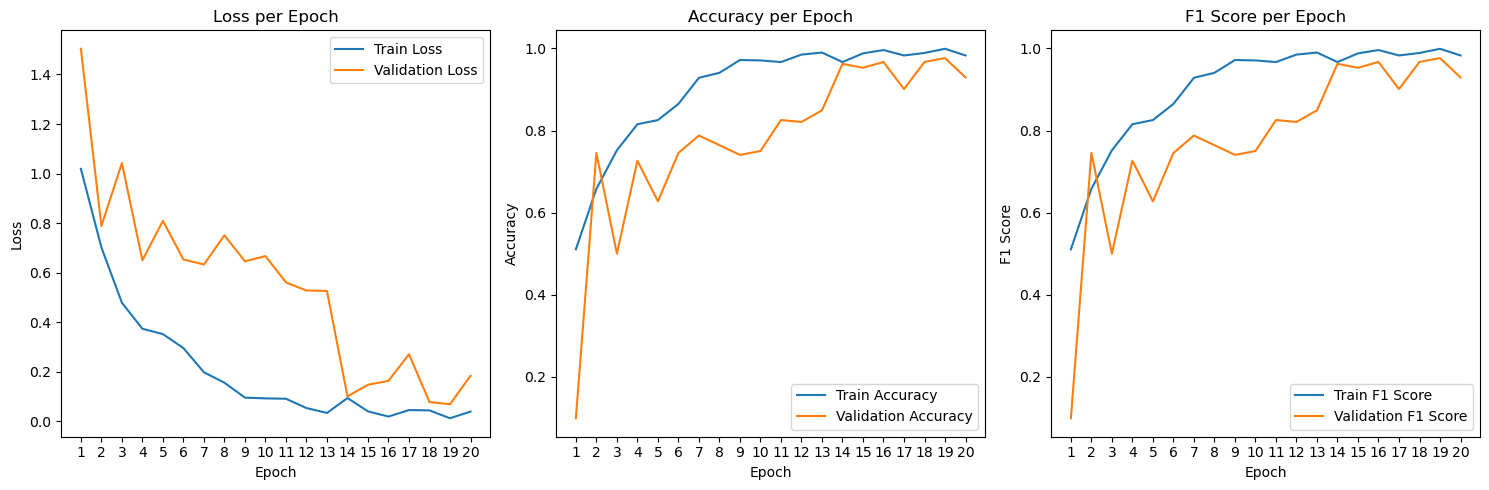

In [ ]:
plot("./log/CRNN-train-log.json")

# Evaluation Model Performance (Test)

In [ ]:
import os
import torch
from torch import nn
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np  # Import numpy for calculations

def validate(model, model_save_dir, modelName, last_epoch, val_loader, device, num_classes, adv=False):
    model.to(device)
    version = 'Adversarial' if adv else 'Standard'
    model_save_path = os.path.join(f'{model_save_dir}/{modelName}', f'{"adv" if adv else ""}epoch_{last_epoch}.pth')

    if os.path.isfile(model_save_path):
        model.load_state_dict(torch.load(model_save_path, map_location=device))
    else:
        print(f"No pretrained model found at {model_save_path}.")
        return

    criterion = nn.CrossEntropyLoss()
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())

    # Compute the metrics
    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total
    f1_macro = f1_score(all_labels, all_preds, average='macro')

    # Print the results
    print(f'{version} Model - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1 Macro: {f1_macro:.4f}')

    # Calculate and normalize the confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize each row to sum to 1

    print('Confusion Matrix:')
    # print(cm_percentage)  # Display the percentage matrix

    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_percentage, annot=True, fmt=".2%", cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for {version} Model')
    plt.show()

    return

Val + Test Set Evaluation:
Standard Model - Loss: 0.0573, Accuracy: 0.9836, F1 Macro: 0.9737
Confusion Matrix:


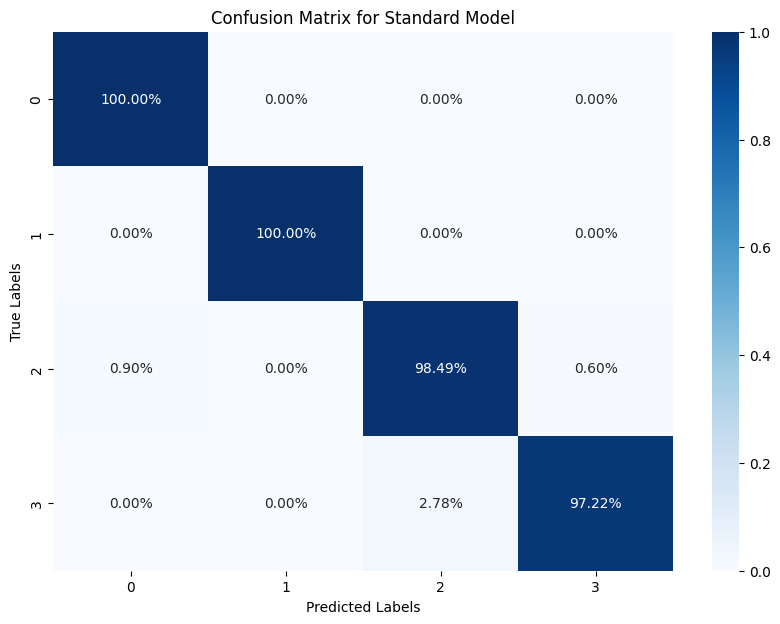

In [ ]:
model_checkpoint_path = 'ModelCheckpointsDebug'
model_name = 'CRNNModel'

crnn_model = CRNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
crnn_model.to(device)

print("Val + Test Set Evaluation:")
validate(crnn_model,model_checkpoint_path,model_name,18,combined_loader,device,4)

# Calculate total model parameters

In [ ]:
model = CRNN()
model.load_state_dict(torch.load('ModelCheckpoints/epoch_17.pth',map_location=torch.device('cpu')))
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {trainable_params}")

Total trainable parameters: 257628
